In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
data=pd.read_csv('./data/household_power_consumption.txt',sep=';', header=0, low_memory=False, infer_datetime_format=True, 
                 parse_dates={'datetime':[0,1]}, index_col=['datetime'])
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [84]:
data.replace('?',np.nan, inplace=True)
data=data.astype('float32')

In [85]:
data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [86]:
data=data.fillna(data.mean())
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [87]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091373e+00,1.237164e-01,2.435335e+02,4.630594e+00,1.121211e+00,1.298031e+00,6.454503e+00
std,1.050167e+00,1.121103e-01,4.183342e+00,4.412327e+00,6.065988e+00,5.722075e+00,8.405821e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.410500e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.429700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [88]:
data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.398231,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.111817,0.266120,0.123111,0.139231,0.089617
Voltage,-0.398231,-0.111817,1.000000,-0.409785,-0.195225,-0.166764,-0.267145
Global_intensity,0.998889,0.266120,-0.409785,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195225,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.166764,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.267145,0.626543,0.102571,0.080872,1.000000


In [89]:
resampled_data = data.resample('D').sum()
resampled_data = resampled_data.reset_index()
resampled_data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


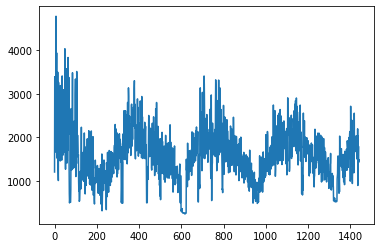

In [90]:
plt.plot(resampled_data.index,resampled_data.Global_active_power)

In [91]:
resampled_data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.041098,0.062393,0.999182,0.545338,0.481370,0.732613
Global_reactive_power,0.041098,1.000000,0.050946,0.062937,0.319394,0.182199,0.035568
Voltage,0.062393,0.050946,1.000000,0.052214,-0.003525,-0.013305,0.095189
Global_intensity,0.999182,0.062937,0.052214,1.000000,0.557975,0.490773,0.724145
Sub_metering_1,0.545338,0.319394,-0.003525,0.557975,1.000000,0.251585,0.308917
Sub_metering_2,0.481370,0.182199,-0.013305,0.490773,0.251585,1.000000,0.198360
Sub_metering_3,0.732613,0.035568,0.095189,0.724145,0.308917,0.198360,1.000000


In [92]:
from scipy.stats import pearsonr
corr,_= pearsonr(resampled_data['Global_active_power'],resampled_data['Global_reactive_power'])
corr

0.04109788470945897

In [93]:
corr2,_ = pearsonr(resampled_data['Voltage'],resampled_data['Global_intensity'])
corr2

0.05221350712869457

In [94]:
columns={"datetime": "ds", "Global_active_power": "y"}
X_train = resampled_data[:-365]
X_test = resampled_data[-365:]
X_train = X_train.rename(columns=columns)
X_test = X_test.rename(columns=columns)

In [95]:
X_train=X_train.iloc[:,:2]
X_train.head()

,ds,y
0,2006-12-16,1209.176025
1,2006-12-17,3390.459961
2,2006-12-18,2203.825928
3,2006-12-19,1666.193970
4,2006-12-20,2225.748047


In [96]:
X_test=X_test.iloc[:,:2]
X_test.head()

,ds,y
1077,2009-11-27,1380.026001
1078,2009-11-28,1858.949951
1079,2009-11-29,1650.962036
1080,2009-11-30,1745.189941
1081,2009-12-01,1756.378052


In [97]:
from fbprophet import Prophet
model=Prophet()
model.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [98]:
forecast = model.predict(X_test) 
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1580.084009,1538.098939,2655.419310,1580.084009,1580.084009,519.056899,519.056899,519.056899,-64.127019,-64.127019,-64.127019,583.183918,583.183918,583.183918,0.0,0.0,0.0,2099.140908
1,2009-11-28,1580.207768,1874.097743,2996.493841,1580.207768,1580.207768,822.213567,822.213567,822.213567,245.813256,245.813256,245.813256,576.400311,576.400311,576.400311,0.0,0.0,0.0,2402.421335
2,2009-11-29,1580.331526,1781.560735,2936.906976,1580.331526,1580.331526,796.157722,796.157722,796.157722,228.519177,228.519177,228.519177,567.638545,567.638545,567.638545,0.0,0.0,0.0,2376.489248
3,2009-11-30,1580.455285,1420.280691,2546.490800,1580.455285,1580.455285,396.118617,396.118617,396.118617,-161.286790,-161.286790,-161.286790,557.405408,557.405408,557.405408,0.0,0.0,0.0,1976.573902
4,2009-12-01,1580.579043,1526.008489,2662.526742,1580.579043,1580.579043,516.895388,516.895388,516.895388,-29.332428,-29.332428,-29.332428,546.227816,546.227816,546.227816,0.0,0.0,0.0,2097.474431


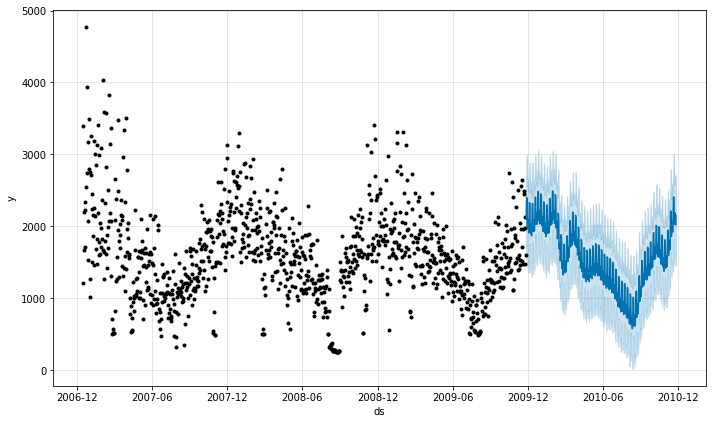

In [99]:
model.plot(forecast,uncertainty=True);

In [100]:
from sklearn import metrics
def mean_absolute_percentage_error(y,y_pred):
  y,y_pred = np.array(y), np.array(y_pred)
  return np.mean(np.abs((y - y_pred)/y)) *100
mape=mean_absolute_percentage_error(X_test['y'],forecast['yhat'])
mape

20.815831963532684

In [101]:
rmse = np.sqrt(metrics.mean_squared_error(X_test['y'],forecast['yhat']))
rmse

374.604233946713

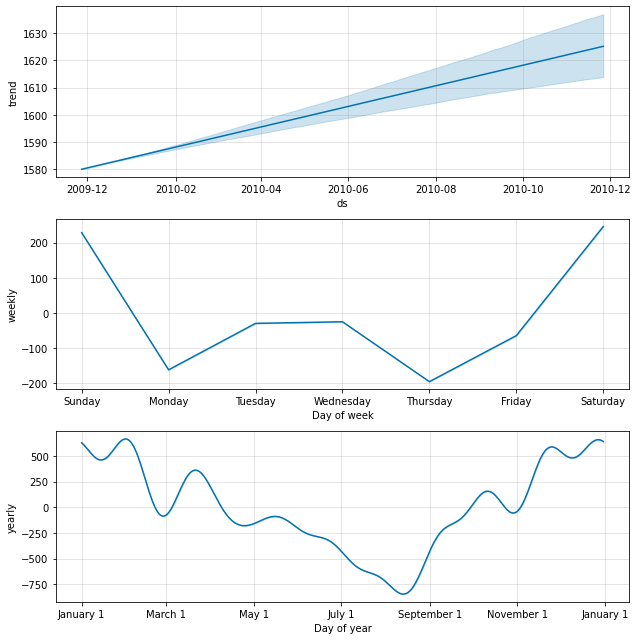

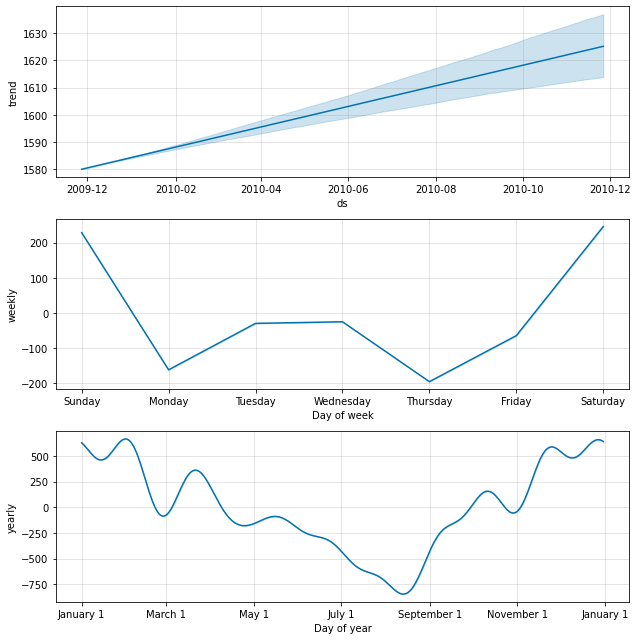

In [102]:
model.plot_components(forecast)

In [103]:
resampled_data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [104]:
columns={'datetime':'ds','Global_active_power':'y',
        'Global_reactive_power':'add1','Voltage':'add2',
        'Global_intensity':'add3','Sub_metering_1':'add4',
        'Sub_metering_2':'add5','Sub_metering_3':'add6'};
new_data = resampled_data.rename(columns = columns)
new_data.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [105]:
new_train=new_data[:-365]
new_test=new_data[-365:]

In [106]:
model = Prophet()
model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')
model.add_regressor('add4')
model.add_regressor('add5')
model.add_regressor('add6')

In [107]:
model = model.fit(new_train)
new_pred = model.predict(new_test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
new_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,add2_lower,add2_upper,add3,add3_lower,add3_upper,add4,add4_lower,add4_upper,add5,add5_lower,add5_upper,add6,add6_lower,add6_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1597.207251,1362.956407,1397.388265,1597.207251,1597.207251,7.516635,7.516635,7.516635,0.616011,0.616011,0.616011,-232.333805,-232.333805,-232.333805,2.202791,2.202791,2.202791,0.825649,0.825649,0.825649,3.864961,3.864961,3.864961,-216.018146,-216.018146,-216.018146,-217.307759,-217.307759,-217.307759,-0.101979,-0.101979,-0.101979,1.391591,1.391591,1.391591,0.0,0.0,0.0,1381.189105
1,2009-11-28,1597.347956,1845.279372,1877.083007,1597.347956,1597.347956,-8.857395,-8.857395,-8.857395,0.505812,0.505812,0.505812,263.405656,263.405656,263.405656,-2.028400,-2.028400,-2.028400,0.830930,0.830930,0.830930,7.751815,7.751815,7.751815,264.708105,264.708105,264.708105,261.608418,261.608418,261.608418,1.386425,1.386425,1.386425,1.713262,1.713262,1.713262,0.0,0.0,0.0,1862.056061
2,2009-11-29,1597.488661,1629.121530,1659.855539,1597.488661,1597.488661,-2.788241,-2.788241,-2.788241,1.224994,1.224994,1.224994,47.460713,47.460713,47.460713,0.783576,0.783576,0.783576,-0.581772,-0.581772,-0.581772,-1.463038,-1.463038,-1.463038,46.847909,46.847909,46.847909,44.636232,44.636232,44.636232,0.141167,0.141167,0.141167,2.070510,2.070510,2.070510,0.0,0.0,0.0,1644.336570
3,2009-11-30,1597.629366,1726.442513,1758.345956,1597.629366,1597.629366,3.904847,3.904847,3.904847,1.416343,1.416343,1.416343,131.751742,131.751742,131.751742,0.774317,0.774317,0.774317,0.844133,0.844133,0.844133,4.486631,4.486631,4.486631,145.311316,145.311316,145.311316,143.178013,143.178013,143.178013,-0.334593,-0.334593,-0.334593,2.467896,2.467896,2.467896,0.0,0.0,0.0,1742.940683
4,2009-12-01,1597.770071,1746.930676,1778.781520,1597.770071,1597.770071,5.949337,5.949337,5.949337,0.941248,0.941248,0.941248,150.954176,150.954176,150.954176,2.202791,2.202791,2.202791,0.847829,0.847829,0.847829,2.765734,2.765734,2.765734,164.911595,164.911595,164.911595,163.661116,163.661116,163.661116,-1.658690,-1.658690,-1.658690,2.909169,2.909169,2.909169,0.0,0.0,0.0,1762.681666


In [113]:
mape=mean_absolute_percentage_error(new_test['y'],new_pred['yhat'])
mape

3.0445761457342444

In [114]:
rmse = np.sqrt(metrics.mean_squared_error(new_test['y'],new_pred['yhat']))
rmse

44.87909204303396

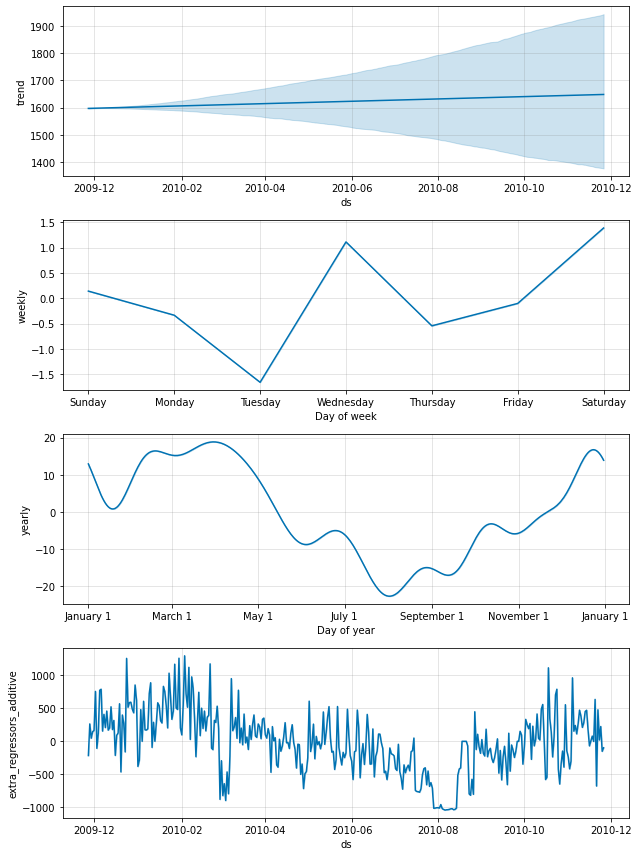

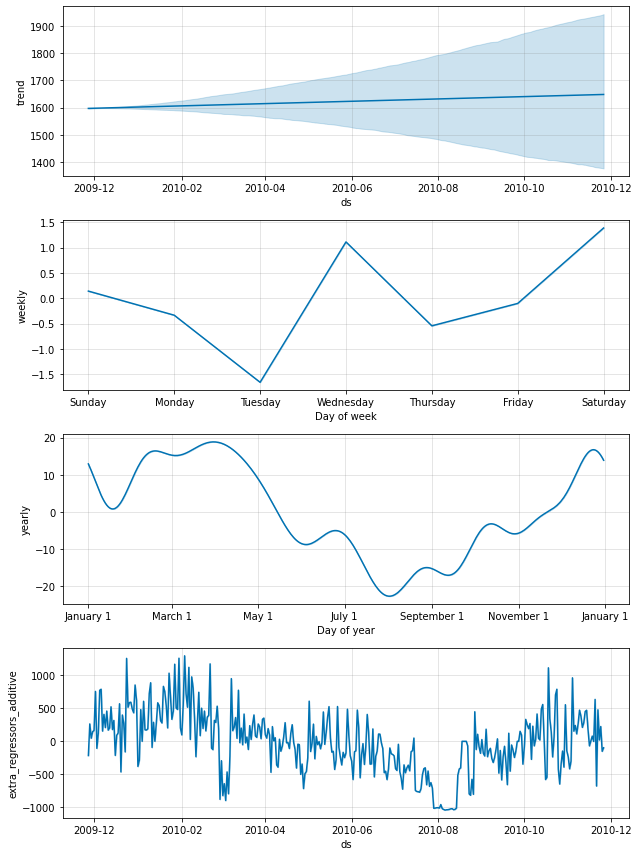

In [115]:
model.plot_components(new_pred)